# Emotion Recognition from Speech Machine learning & Deep Learning


**Model: LSTM-based Emotion Recognition**

* Utilizes LSTM neural networks for sequential data processing.
* Preprocesses speech audio data using techniques like MFCCs for feature extraction.
* Trained on a labeled dataset containing emotions such as happiness, anger, sadness.
* Implements LSTM architecture with appropriate layers.
* Augments dataset if needed for diversity.
* Employs dropout and batch normalization to prevent overfitting.
* Evaluates performance using metrics like accuracy, precision, recall.
* Hyperparameter tuning for optimization.
* Deploys for real-time or recorded audio emotion classification.

**Emotions: Neutral, Disgust, Happy, Sad, Fear, Angry, Surprise**

In [58]:
import os
os.chdir('/kaggle/working/')

In [59]:
!ls

best_model1_weights.h5	emotion.csv  speech_cnn_new_model.h5
data_path.csv		file.zip


**Import libraries**

In [60]:
import os
import sys
import keras
import librosa
import timeit
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
from joblib import Parallel, delayed
import IPython.display as ipd
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


**Update package information and install libsndfile1 for audio processing.**

In [61]:
!apt-get update
!apt-get install -y libsndfile1

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease               
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:5 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:6 https://packages.cloud.google.com/apt cloud-sdk InRelease
Hit:7 https://packages.cloud.google.com/apt google-fast-socket InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 114 kB in 2s (68.2 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-7ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


In [62]:
!pip install --upgrade librosa

In [63]:
!pip show librosa

Name: librosa
Version: 0.10.1
Summary: Python module for audio and music processing
Home-page: https://librosa.org
Author: Brian McFee, librosa development team
Author-email: brian.mcfee@nyu.edu
License: ISC
Location: /opt/conda/lib/python3.10/site-packages
Requires: audioread, decorator, joblib, lazy-loader, msgpack, numba, numpy, pooch, scikit-learn, scipy, soundfile, soxr, typing-extensions
Required-by: 


**Load dataset**

In [64]:
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
# print(ravdess_directory_list)
Crema = "/kaggle/input/cremad/AudioWAV/"
Crema_directory_list = os.listdir(Crema)
# print(Crema_directory_list)
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
Tess_directory_list = os.listdir(Tess)
# print(Tess_directory_list)
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
Savee_directory_list = os.listdir(Savee)
# print(Savee_directory_list)

# **Preprocessing**

**Ravdees**

In [65]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    # print(actor)
    for f in actor:
        # print(f)
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [66]:
# Print the first element of the 'actor' list
print(actor[0])

# Print the first element of the 'part' list
print(part[0])

# Print the first element of the 'file_path' list
print(file_path[0])

# Convert the third element of the 'part' list to an integer and print it
print(int(part[2]))

# Print the value stored in the variable 'f'
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [67]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

**CREMA-D**
* 7,442 video clips
* 91 actors (48 males, 43 females)
* Ages 20 to 74, diverse racial/ethnic backgrounds
* 12 sentences expressing 6 emotions (Anger, Disgust, Fear, Happy, Neutral, Sad)
* Emotion levels: Low, Medium, High, Unspecified
* Valuable for emotion recognition research, offers insights into cross-cultural and age-related differences.

In [68]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS**
* Two actresses, aged 26 and 64.
* They spoke 200 target words in the phrase "Say the word _".
* Emotions expressed:
   * Anger
   * Disgust
   * Fear
   * Happiness
   * Pleasant Surprise
   * Sadness
   * Neutral
* Recordings made for each emotion.
* Total of 2800 audio files in WAV format.
* Dataset organized by actress, with separate folders for each emotion.
* Within emotion folders, audio files for all 200 target words.

In [69]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


**SAVEE**
* SAVEE database recorded by four English-speaking men:
  * DC
  * JE
  * JK
  * KL.
* All speakers were postgraduate students and researchers at the University of Surrey, aged 27 to 31.
* Emotions categorized as,
  * Anger
  * Disgust
  * Fear
  * Happiness
  * Sadness
  * Surprise
  * Neutral.
* Neutral included to ensure recordings for all 7 emotion categories.
* Text material comprised 15 TIMIT sentences for each emotion.
* Each emotion had 3 common, 2 emotion-specific, and 10 generic sentences.
* Total of 120 utterances per speaker, covering various emotions and neutral expressions.

In [70]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


**Combine 4 Datasets**

In [72]:
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("/kaggle/working/data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [73]:
print(data_path.Emotions.value_counts())


Emotions
disgust     1923
sad         1923
fear        1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: count, dtype: int64


**EDA**

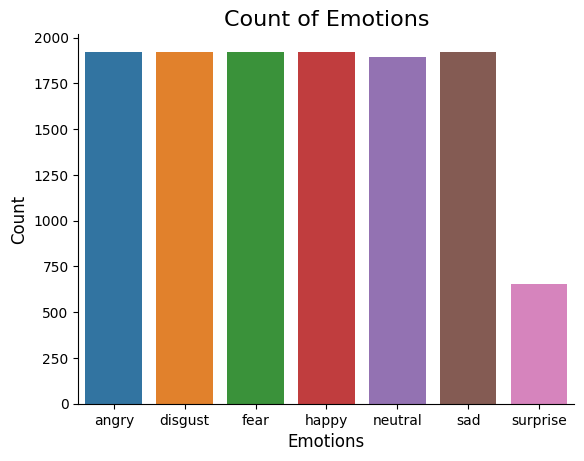

In [74]:
data_path['Emotions'] = data_path['Emotions'].astype('category')
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [75]:
data,sr = librosa.load(file_path[0])
sr

22050

In [76]:
ipd.Audio(data,rate=sr)

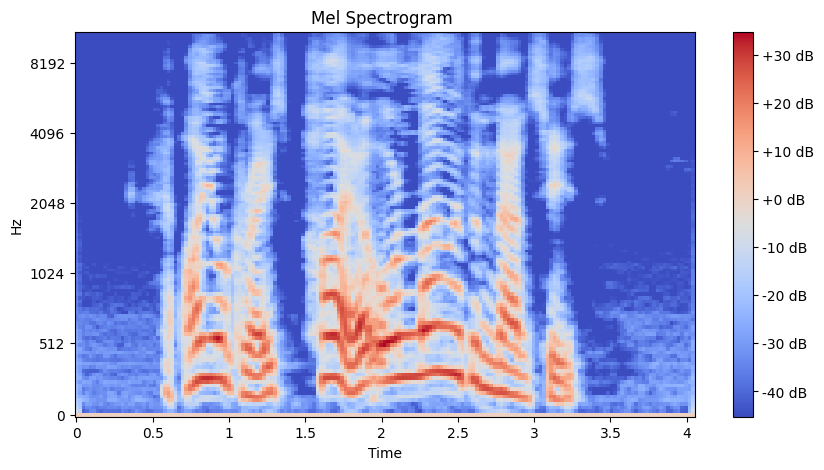

In [77]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

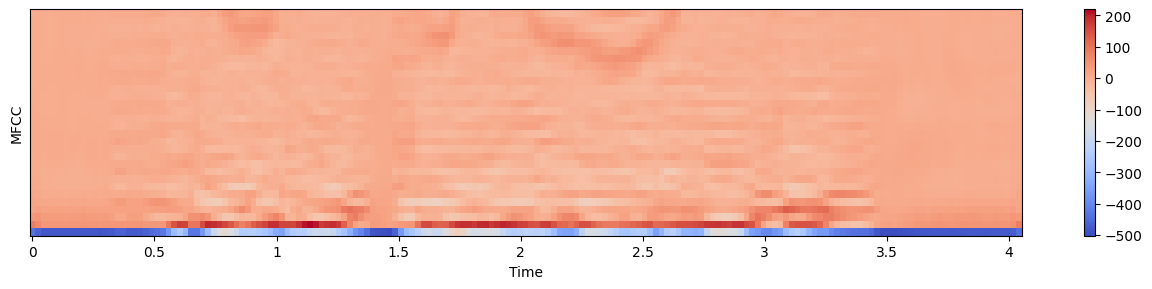

In [78]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
ipd.Audio(data,rate=sr)

**Data augmentation**

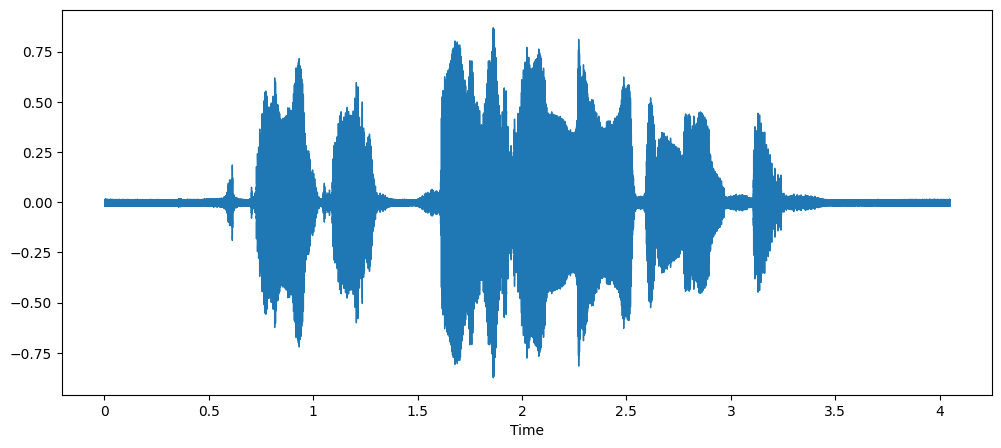

In [79]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

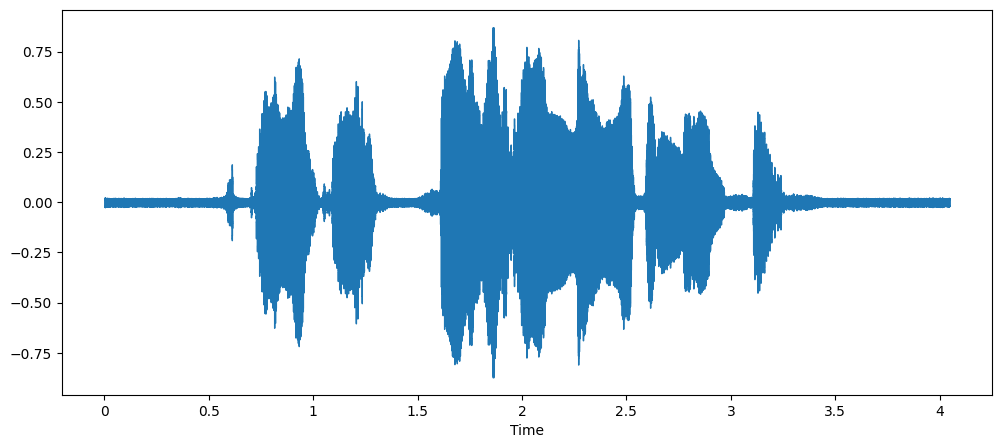

In [80]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

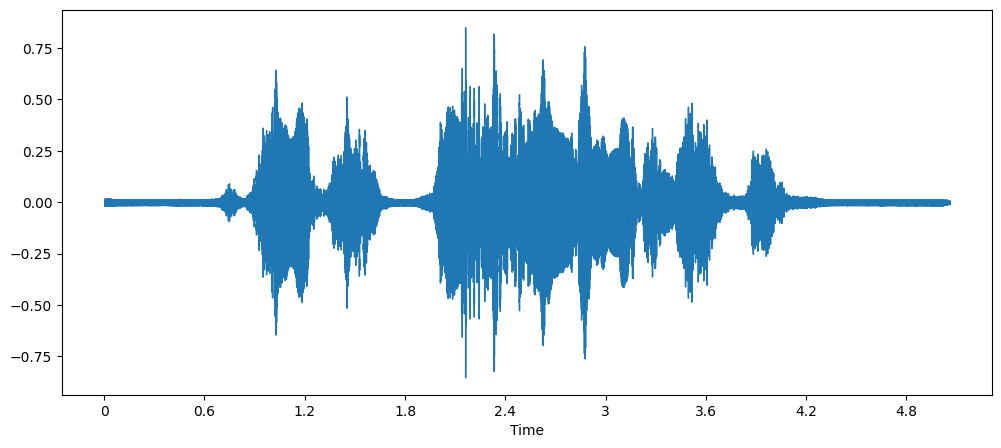

In [81]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)


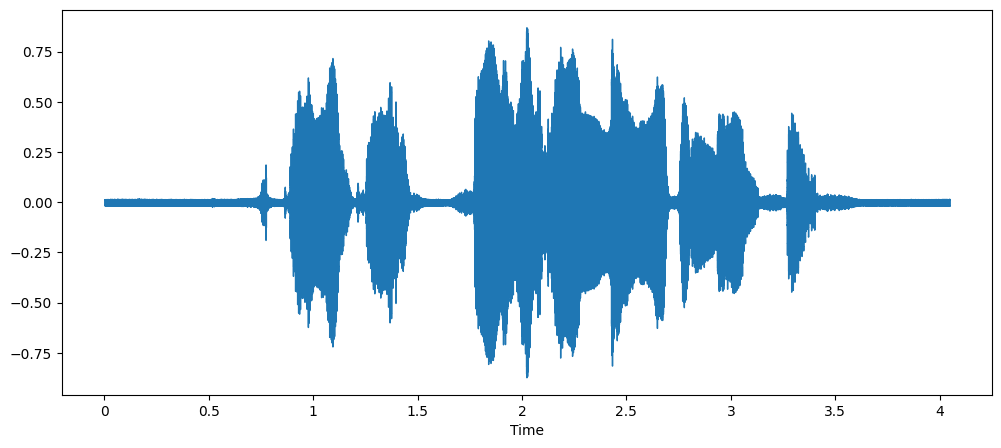

In [82]:
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

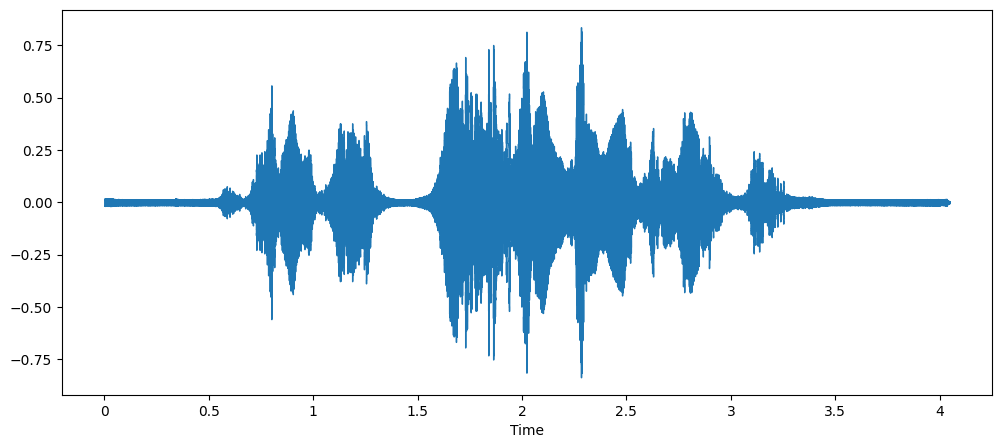

In [83]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

**Feature extraction**

In [97]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

#     pitched_audio=pitch(data,sr)
#     aud3=extract_features(pitched_audio)
#     audio=np.vstack((audio,aud3))

#     pitched_audio1=pitch(data,sr)
#     pitched_noised_audio=noise(pitched_audio1)
#     aud4=extract_features(pitched_noised_audio)
#     audio=np.vstack((audio,aud4))

    return audio


# **Extract Features**

In [98]:
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
#     print("extract features")
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        my_mfcc(data, sr=sr, n_fft=frame_length, hop_length=hop_length)
                        ))
#     print("extract features end")
    return result

def my_mfcc(data, sr, n_fft=2048, hop_length=512, flatten: bool = True):
#     print("mfcc")
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
#     print("mfcc r")
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)


**Extract Features Normally**

In [99]:
# start = timeit.default_timer()
# X, Y = [], []
# for index, (path, emotion) in tqdm(enumerate(zip(data_path.Path, data_path.Emotions))):
#     features = extract_features(path)
#     for i in features:
#         X.append(i)
#         Y.append(emotion)
#     if index % 500 == 0:
#         tqdm.write(f'{index} audio has been processed')
# print('Done')
# stop = timeit.default_timer()
# print('Time: ', stop - start)

**Faster way**

In [101]:
start = timeit.default_timer()
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  203.69583007300025


In [102]:
len(X), len(Y), data_path.Path.shape

(24324, 24324, (12162,))

**Save features to dataframe and preprocess**

In [103]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.240723,0.360352,0.485840,0.490234,0.485840,0.491699,0.491699,0.478027,0.486816,0.478027,...,5.868534,5.873579,2.725916,3.312219,4.315032,5.116044,6.863636,0.399570,2.999261,surprise
2,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral
3,0.250488,0.379883,0.502930,0.490234,0.493652,0.486328,0.486328,0.491699,0.498047,0.505371,...,-4.110920,3.441641,1.436614,-0.423368,0.290940,-4.183457,-1.651272,3.940107,5.403940,neutral
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.063477,0.176758,0.176758,0.254883,0.365723,...,-1.825551,-24.133347,18.153677,-15.056425,-7.674027,-13.918596,-5.563495,-7.357308,-0.008657,disgust


In [104]:
Emotions = pd.read_csv('/kaggle/working/emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.240723,0.360352,0.485840,0.490234,0.485840,0.491699,0.491699,0.478027,0.486816,0.478027,...,5.868534,5.873579,2.725916,3.312219,4.315032,5.116044,6.863636,0.399570,2.999261,surprise
2,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral
3,0.250488,0.379883,0.502930,0.490234,0.493652,0.486328,0.486328,0.491699,0.498047,0.505371,...,-4.110920,3.441641,1.436614,-0.423368,0.290940,-4.183457,-1.651272,3.940107,5.403940,neutral
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.063477,0.176758,0.176758,0.254883,0.365723,...,-1.825551,-24.133347,18.153677,-15.056425,-7.674027,-13.918596,-5.563495,-7.357308,-0.008657,disgust


In [105]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [106]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(24324, 2377)

In [108]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

**Prepare Data**

In [109]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [110]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [111]:
print(Y.shape)
X.shape

(24324, 7)


(24324, 2376)

In [112]:
#split data to train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19459, 2376), (19459, 7), (4865, 2376), (4865, 7))

In [113]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [114]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19459, 2376), (19459, 7), (4865, 2376), (4865, 7))

**model parameters**

In [115]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [116]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# **LSTM Model**

In [117]:
model01 = Sequential()
model01.add(LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model01.add(BatchNormalization())
model01.add(Dropout(0.5))

model01.add(LSTM(256, return_sequences=True))
model01.add(BatchNormalization())
model01.add(Dropout(0.5))

model01.add(LSTM(128, return_sequences=True))
model01.add(BatchNormalization())
model01.add(Dropout(0.2))

model01.add(LSTM(128, return_sequences=True))
model01.add(BatchNormalization())
model01.add(Dropout(0.2))

model01.add(LSTM(64, return_sequences=True))
model01.add(BatchNormalization())
model01.add(Dropout(0.2))

model01.add(LSTM(32))
model01.add(BatchNormalization())
model01.add(Dropout(0.2))

model01.add(Dense(7, activation='softmax'))

model01.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model01.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2376, 512)         1052672   
                                                                 
 batch_normalization_6 (Bat  (None, 2376, 512)         2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2376, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, 2376, 256)         787456    
                                                                 
 batch_normalization_7 (Bat  (None, 2376, 256)         1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 2376, 256)        

**model training**

In [119]:
hist=model01.fit(X_train, y_train,
            epochs=10,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)

Epoch 1/10
305/305 [==============================] - 354s 1s/step - loss: 1.9374 - accuracy: 0.1664 - val_loss: 1.9092 - val_accuracy: 0.1920
Epoch 2/10
305/305 [==============================] - 351s 1s/step - loss: 1.9164 - accuracy: 0.1770 - val_loss: 1.8873 - val_accuracy: 0.1797
Epoch 3/10
305/305 [==============================] - 353s 1s/step - loss: 1.9052 - accuracy: 0.1736 - val_loss: 1.8774 - val_accuracy: 0.1879
Epoch 4/10
305/305 [==============================] - 352s 1s/step - loss: 1.8837 - accuracy: 0.1939 - val_loss: 1.8495 - val_accuracy: 0.2160
Epoch 5/10
305/305 [==============================] - 354s 1s/step - loss: 1.8450 - accuracy: 0.2196 - val_loss: 1.8362 - val_accuracy: 0.2236
Epoch 6/10
305/305 [==============================] - 351s 1s/step - loss: 1.8342 - accuracy: 0.2238 - val_loss: 1.8497 - val_accuracy: 0.2284
Epoch 7/10
305/305 [==============================] - 351s 1s/step - loss: 1.8358 - accuracy: 0.2290 - val_loss: 1.8150 - val_accuracy: 0.2240

**plots**

153/153 [==============================] - 57s 374ms/step - loss: 1.8980 - accuracy: 0.1920
Accuracy of our model on test data :  19.198355078697205 %


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

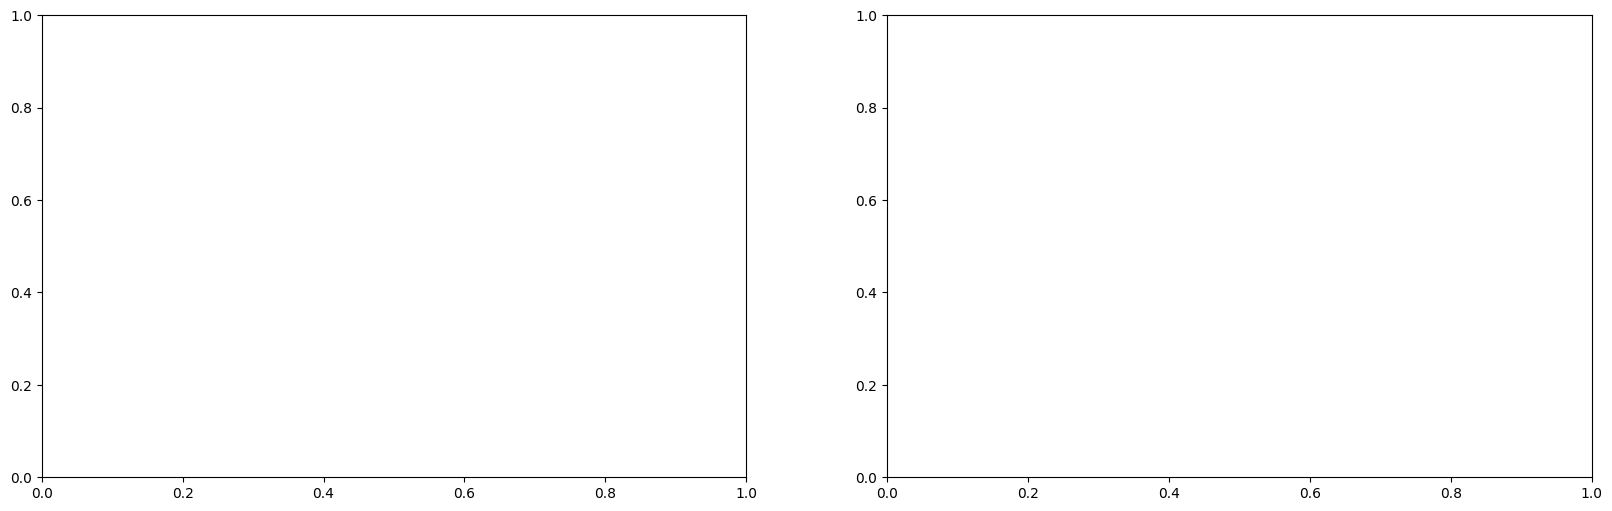

In [120]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

**save model weights**

In [121]:
model_save_path = '/kaggle/working/speech_lstm_new_model.h5'
model01.save(model_save_path)
print("Model saved successfully at:", model_save_path)

Model saved successfully at: /kaggle/working/speech_lstm_new_model.h5


**check prediction on test data**

In [122]:
pred_test0 = model01.predict(x_test)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(50)

153/153 [==============================] - 58s 369ms/step


,Predicted Labels,Actual Labels
0,fear,neutral
1,happy,neutral
2,happy,disgust
3,happy,happy
4,happy,angry
5,fear,fear
6,happy,neutral
7,happy,neutral
8,fear,angry
9,happy,happy


**model evaluation**

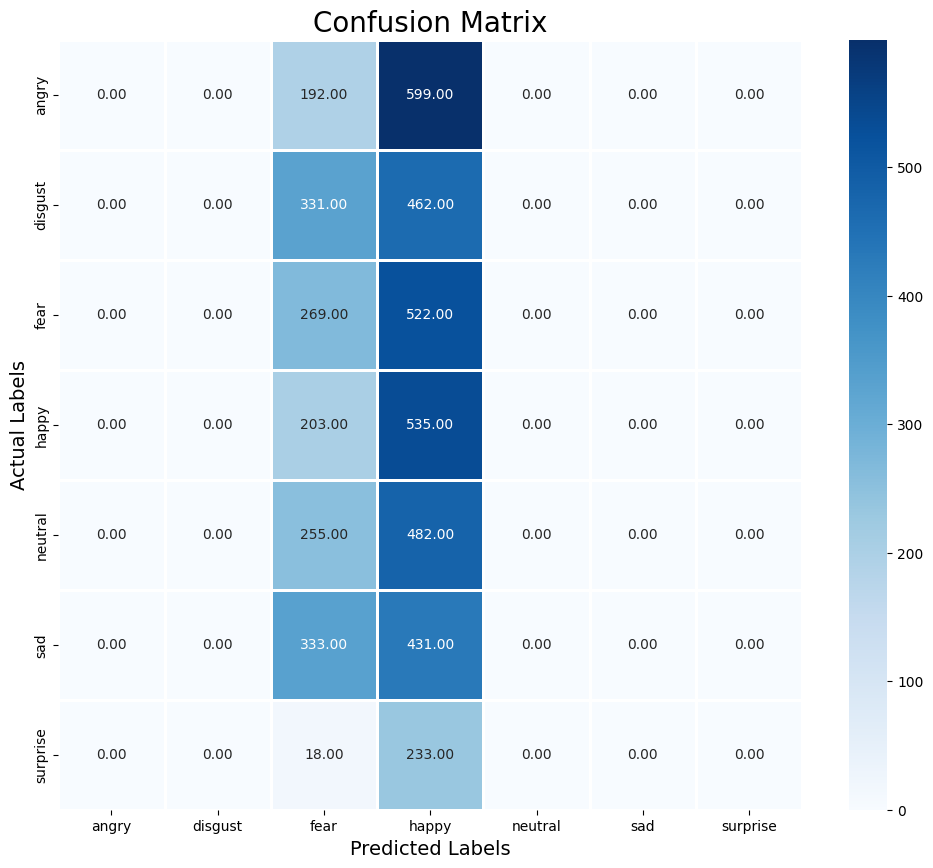

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       791
     disgust       0.00      0.00      0.00       793
        fear       0.17      0.34      0.22       791
       happy       0.16      0.72      0.27       738
     neutral       0.00      0.00      0.00       737
         sad       0.00      0.00      0.00       764
    surprise       0.00      0.00      0.00       251

    accuracy                           0.17      4865
   macro avg       0.05      0.15      0.07      4865
weighted avg       0.05      0.17      0.08      4865



In [123]:
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [124]:
from IPython.display import FileLink
FileLink(r'speech_lstm_new_model.h5')

/kaggle/working/speech_lstm_new_model.h5